In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class RBFKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_centers):
        super(RBFKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.num_centers = num_centers

        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.weights = nn.Parameter(torch.randn(num_centers, output_dim))
        self.sigmas = nn.Parameter(torch.randn(num_centers))

    def forward(self, x):
        distances = torch.cdist(x, self.centers)
        rbf_activations = torch.exp(-distances ** 2 / (2 * self.sigmas ** 2))
        output = torch.matmul(rbf_activations, self.weights)
        return output

Epoch 100, Loss: 0.019804242998361588
Epoch 200, Loss: 0.0002346499531995505


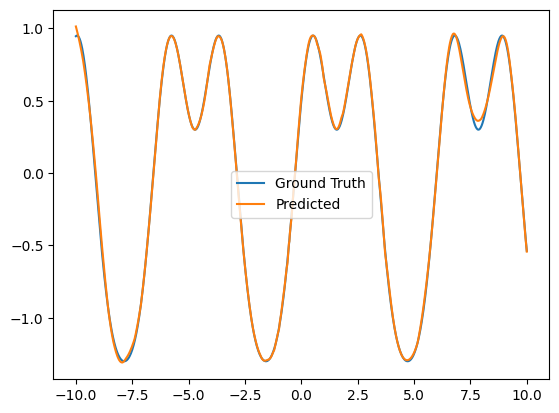

In [4]:
class ComplexNetwork(nn.Module):
    def __init__(self):
        super(ComplexNetwork, self).__init__()
        self.layer1 = RBFKANLayer(1, 20, 50)
        self.layer2 = nn.ReLU()
        self.layer3 = RBFKANLayer(20, 20, 50)
        self.layer4 = nn.ReLU()
        self.layer5 = RBFKANLayer(20, 1, 20)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

# Create a curve
x = np.linspace(-10, 10, 1000)
y = np.sin(x) + 0.5 * np.cos(2 * x) + 0.2 * np.sin(3 * x)

# Convert the data to tensors
x = torch.from_numpy(x).float().unsqueeze(1)
y = torch.from_numpy(y).float().unsqueeze(1)

# Create a data loader
dataset = torch.utils.data.TensorDataset(x, y)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Create the model and optimizer
model = ComplexNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(200):
    for x_batch, y_batch in data_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = nn.MSELoss()(output, y_batch)
        loss.backward()
        optimizer.step()
    
    # Print the loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

x_test = torch.from_numpy(np.linspace(-10, 10, 1000)).float().unsqueeze(1)
output = model(x_test)
output = output.detach().numpy()

plt.plot(x_test.numpy(), y.numpy(), label='Ground Truth')
plt.plot(x_test.numpy(), output, label='Predicted')
plt.legend()
plt.show()